# Mass-Radius relation for a Fermion-Boson Star

So, basically I want to reproduce the findings in https://arxiv.org/pdf/2110.11997.pdf, where the TOV equations are solved for a complex scalar field, which might play the role of DM and additionally fermionic matter, which takes the role of ordinary matter (such as neutrons in our case). The EoS for the fermionic part is therefore chosen among tabulated ones that are calculated for neutron stars.

The goal of the paper is to explore how the mass-radius relation can be modified by introducing the bosonic matter in order to make it compatible with recent observations. These observations are:

- ???: PSR J1614-2230 & PSR J0348+0432 have masses close to 2 $\textup{M}_\odot$ (Only the mass was measured accurately)
- NICER: <span style="color:green">PSR J0030+0451</span> has $M \approx 1.4 \textup{M}_\odot$ and $r \approx 13$ km
- NICER + XMM-Newton: <span style="color:red">PSR J0740+6620</span> has $M \approx 2.08 \textup{M}_\odot$ and $r \approx 13$ km
- GW170817
- GW190814: the secondary object has an estimated mass of $2.50 - 2.67 \textup{M}_\odot$, which is quite heavy for a NS (so maybe it's actually a black hole ¯\\\_(ツ)\_/¯)


Especially the fact that <span style="color:green">PSR J0030+0451</span> and <span style="color:red">PSR J0740+6620</span> have similar radii, but quite different masses is interesting.

Things that I find a bit weird about the paper:
- I am a bit confused about the units they use. Since they have $c = G = \hbar = 1$, I would expect a mass of $m = 1$ to translate to $m = 1\,m_\text{pl} \approx 10^{19}\,\text{GeV}$, but they say that $m = 1$ corresponds to $m = 1.34 \times 10^{-11}\,\text{eV}$ (page 4 bottom left corner). Ok, I figured it out. It's described in appendix A of https://arxiv.org/pdf/1807.06959.pdf


Some notes about this work and it's context:
- The current work does not consider self-interactions (e.g. $\lambda = 0$)
- The authors published several papers in a series, investigating fermion-boson stars. The other ones seem to be about stability and formation processes. See e.g. https://arxiv.org/pdf/2006.08583.pdf, https://arxiv.org/pdf/2105.00530.pdf

# About units

We are using units such that $G = c = \textup{M}_\odot = 1$. This means that units of length are given by

\begin{align}
\begin{split}
    \text{[length]} &= \frac{G  \textup{M}_\odot}{c^2} \approx 1.477\,\text{km} = 1.477 \times 10^{18}\,\text{fm} \\
    \text{[mass density]} &= \text{[mass / length$^3$]} \approx 0.31\, \textup{M}_\odot / \text{km}^3 \approx 1.988 \times 10^{21}\, \text{kg/m}^3 \\
    \text{[energy density]} &\approx 5.55 \times 10^{37}\,\text{J/m}^3 \\
    \text{[energy]} &= \textup{M}_\odot c^2 \approx 1.787 \times 10^{47}\,\text{J} \approx 2.863 \times 10^{65}\, \text{eV} \\
    1\,\text{MeV/fm}^3 &\approx 1.602 \times 10^{-13}\,\text{J/fm}^3 = 1.602 \times 10^{32}\,\text{J/m}^3
\end{split}
\end{align}

For example, if we have a (rest) mass density of $0.0012$ (this is a value that was also used in the paper), then in SI units this corresponds to $0.0012 \times 1.988 \times 10^{21}\, \text{kg/m}^3 = 2.3856 \times 10^{18} \text{kg/m}^3$. Which is roughly ten times nuclear density. This means, if I want to convert from $\text{MeV/fm}^3$ to code units, then I only have to multiply the value by $2.88 \times 10^{-6}$.


# EoS class

The following class can load a equation of state table as created by compose and convert it into code units. The table should be in the same directory as this notebook.

In [38]:
import numpy as np

class EoS:
    neutron_mass = 939.565379 # MeV

    def __init__(self, name):
        self.name = name
        self.load()
    
    def load(self):
        self.raw_data = np.loadtxt(self.name + "_" + "eos.table").T

        # the following is in compose units
        self.baryonNumberDensity = self.raw_data[1] # fm^-3
        self.pressure = self.raw_data[3] # MeV fm^-3
        self.totalEnergyPerBaryon = self.raw_data[4] # MeV
        self.totalEnergyDensity = self.raw_data[4] # MeV fm^-3
        self.restMassDensity = self.raw_data[1] * self.neutron_mass # MeV fm^-3

        # the following is in code units (c = G = Msun = 1). Code units are depicted with cu
        self.pressure_cu = self.raw_data[3] * 2.88e-6
        # self.totalEnergyPerBaryon_cu = self.raw_data[4]
        self.totalEnergyDensity_cu = self.raw_data[4] * 2.88e-6
        self.restMassDensity_cu = self.raw_data[1] * self.neutron_mass * 2.886e-6
        self.amtEntries = len(self.pressure)

        self.totalEnergyDensity_vs_pressure_cu = lambda x : np.interp(x, self.pressure_cu, self.totalEnergyDensity_cu)

    def get_restMassDensity(self, pressure):
        # the pressure array has the increasing values, so we only have to find the index where it is first smaller than the current array entry
        for i in range(self.amtEntries):
            currVal = self.pressure_cu[i]
            if pressure < currVal:
                return self.restMassDensity_cu[i] # TODO here I should be interpolating between the neirest neighbors
        return -1

    def get_totalEnergyDensity(self, pressure):
        # the pressure array has the increasing values, so we only have to find the index where it is first smaller than the current array entry
        
        return self.totalEnergyDensity_vs_pressure_cu(pressure)
        '''
        for i in range(self.amtEntries):
            currVal = self.pressure_cu[i]
            if pressure < currVal:
                return self.totalEnergyDensity_cu[i] # TODO here I should be interpolating between the neirest neighbors
        return -1
        '''

# Getting to work: solving the equations

The following section includes the code to solve the modified TOV equation and perform the shooting procedure in order to obtain the frequency for the scalar field.

In [39]:
import numpy as np
from scipy.integrate import solve_ivp # I use solve_ivp instead of odeint. odeint might be faster, but solve_ivp allows to specify the used integration method
from scipy.optimize import fsolve # used to find the eigenvalue omega (i.e. carrying out the shooting method)
import matplotlib.pyplot as plt

pi = np.pi
mu = 1 # the mass of the bosonic field
lam = 0 # the self-interaction parameter in the quartic coupling

# the min and max radius between which the ODEs are solved
minRadius = 1e-5
maxRadius = 2000

# Here we load the DD2 equation of state. (The table with the data should be in the same directory as this notebook)
EoS_v = EoS("DD2")

# equation of state
def EoS_polytrope_pressure(rho):
    K = 100
    gamma = 2
    return K * rho**gamma

def EoS_polytrope_rho(P):
    K = 100
    gamma = 2
    return (P / K)**(1 / gamma)

# this functions returns df/dr (we assume spherical symmetry in all components)
def fun(r, y):
    # using the same order and notation as in the paper
    a = y[0] # this the radial factor in the metric
    alpha = y[1] # this the time factor in the metric
    phi = y[2] # this the field value of the bosonic field 
    psi = y[3] # this just the radial derivative of phi (= dphi/dr)
    P = y[4] # this the pressure
    omega = y[5] # I am cheating a bit by passing omega as one of the array components (not sure how to do it otherwise)

    if(P < 0): # make sure that the pressure vanishes after we cross the surface (which is defined at P = 0)
        P = 0

    #rho = EoS_polytrope_rho(P)
    rho = EoS_v.get_totalEnergyDensity(P)
    epsilon = 0 # ???

    dadr = a / 2 * ((1 - a*a) / r + 4 * pi * r * ((omega**2/alpha**2 + mu**2 + lam/2 * phi**2) * a**2 * phi**2 + psi**2 + 2 * a**2 * rho * (1 + epsilon)))
    dalphadr = alpha / 2 * ((a*a - 1) / r + 4 * pi * r * ((omega**2/alpha**2 - mu**2 - lam/2 * phi**2) * a**2 * phi**2 + psi**2 + 2 * a**2 * P))
    dphidr = psi
    dpsidr = -(1 + a**2 - 4 * pi * r**2 * a**2 * (mu**2 * phi**2 + lam/2 * phi**4 + rho * (1 + epsilon) - P)) * psi / r - (omega**2 / alpha**2 - mu**2 - lam * phi**2) * a**2 * phi**2
    dPdr = -(rho * (1 + epsilon) + P) * dalphadr / alpha

    return [dadr, dalphadr, dphidr, dpsidr, dPdr, 0]

# this returns a solution to the system of ODEs in terms of phic, rhoc and omega. This is not yet a physical solution though. We have to choose omega so that phic vanishes at infinity
def getProtoSolution(phic, rhoc, omega):
    # initial conditions
    # a = 0, alpha = 0, phi = phi_c, psi = 0, p = K * rho_c^gamma, rho = rho_c (all quantities evaluated at r = 0)
    ac = 1
    alphac = 1  
    psic = 0
    Pc = EoS_polytrope_pressure(rhoc)
    
    r0 = minRadius
    rmax = maxRadius

    y0 = [ac, alphac, phic, psic, Pc, omega]
    # rvals = np.linspace(r0, rmax, 100000)

    return solve_ivp(fun, [r0, rmax], y0, atol = 1e-22, rtol = 1e-10)

# here we take a proto solution and turn it into a physical one by finding the value of omega such that phi goes to 0 for large radii
def getSolution(phic, rhoc):

    res = [1.6]
    
    # I first solve for omega to maximize the possible radius (the ode solver just stops at some radii if a problem occurs and this way we (somewhat) guarantee that we actually solved up to rmax)
    def root_rend(omega):
        guess = getProtoSolution(phic, rhoc, omega[0])
        rend = guess['t'][-1]
        phiend = guess['y'][2][-1]
        return rend - maxRadius

    res = fsolve(root_rend, [abs(res[0])])
    
    # after maximizing the radius we bring phi at it as close to zero as possible to get the most accurate value for omega
    def root_phiend(omega):
        guess = getProtoSolution(phic, rhoc, omega[0])
        rend = guess['t'][-1]
        aend = guess['y'][0][-1]
        alphaend = guess['y'][1][-1]
        phiend = guess['y'][2][-1]
        psiend = guess['y'][3][-1]
        Pend = guess['y'][4][-1]

        derivs = fun(rend, [aend, alphaend, phiend, psiend, Pend, omega])
        dphienddr = derivs[2]

        return abs(dphienddr) + abs(phiend)

    res = fsolve(root_phiend, [abs(res[0])]) # this is the final value for omega
    print(res)
    return getProtoSolution(phic, rhoc, res[0])

'''
    def root_aalpha(omega):
        guess = getProtoSolution(phic, rhoc, omega[0])
        a = guess['y'][0][-1]
        alpha = guess['y'][1][-1]
        return a*alpha - 1
    
    res = fsolve(root_aalpha, [1]) # this is the final value for omega
    print(res)
'''

# returns value for the fermion (NS) radius
def getFermionRadius(solution):
    pressure = solution['y'][4]
    radii = solution['t']
    minPressure = EoS_v.pressure_cu[0]

    #interpolated = lambda r : np.interp(r, radii, P) - minPressure
    solution = fsolve(lambda r : np.interp(r, radii * 1.477, pressure) - minPressure, 10, xtol = 1e-22)
    return solution[0]

# this is the >total< gravitational mass (fermions + bosons)
def getGravitationalMass(solution):
    aend = solution['y'][0][-1]
    alphaend = solution['y'][1][-1]
    rend = solution['t'][-1]

    return rend / 2 * (1 - 1 / aend**2)

# Calculating the mass-radius curve

In [31]:
# first I define the interval that I want to sample by specifying the minimum and maximum cental density
rhomin = 0.0002
rhomax = 0.0043
rhoamt = 50

sampleVals = np.linspace(rhomin, rhomax, rhoamt) # here I now generate all density values that will be used for sampling

# the resulting masses and radii will be saved here
massVals = []
radVals = []

index = 0
for val in sampleVals:
    sol = getProtoSolution(0, val, 0) # get a solution to the corresponding density value

    # get the mass and radii for the current solution
    mass = getGravitationalMass(sol)
    rad = getFermionRadius(sol)

    # check if the mass decreased (altough the density increased). If so, we can stop iterating since all further solutions are unstable
    if len(massVals) != 0 and mass < massVals[-1]:
        print(val)
        break

    # append the obtained values and then repeat
    massVals.append(mass)
    radVals.append(rad)
    index += 1
    if index % 10 == 0:
        print(index)

# I reverse them so that the plot looks nicer (otherwise I had some weird glitch in the curve)
radVals.reverse()
massVals.reverse()

# plot the result
plt.plot(radVals, massVals)
plt.xlim([0, 20])
plt.ylim([0, 3])

# Some debugging

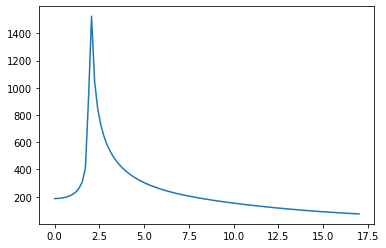

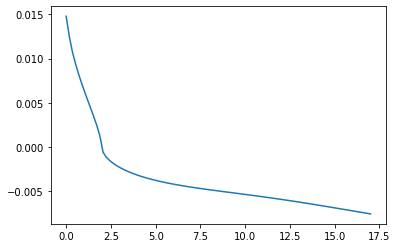

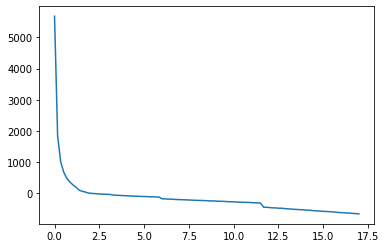

In [13]:
omegaMin = 0
omegaMax = 17
omegaAmt = 100

sampleSpace = np.linspace(omegaMin, omegaMax, omegaAmt)

rVals = []
phiVals = []
dphiVals = []

for val in sampleSpace:
    sol = getProtoSolution(0.0003, 0.002, val)
    rend = sol['t'][-1]

    aend = sol['y'][0][-1]
    alphaend = sol['y'][1][-1]
    phiend = sol['y'][2][-1]
    psiend = sol['y'][3][-1]
    Pend = sol['y'][4][-1]

    derivs = fun(rend, [aend, alphaend, phiend, psiend, Pend, val])
    dphienddr = derivs[2]

    rVals.append(rend)
    phiVals.append(phiend)
    dphiVals.append(dphienddr)

plt.plot(sampleSpace, rVals)
plt.show()
plt.plot(sampleSpace, phiVals)
plt.show()
plt.plot(sampleSpace, dphiVals)
plt.show()